<a href="https://colab.research.google.com/github/AngarosGamer/SAE4/blob/main/spam_filter_MLP_etu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Détection de pourriels par réseau de neurones

# Objectifs du TP

Le courriel indésirable, pourriel, plus communemant appelé spam, représente environ la moitié du courrier électronique mondial [https://securelist.com/spam-phishing-scam-report-2022/108692/]. Une des nombreuses techniques possibles pour les detecter et d'analyser automatiquement le contenu textuel des e-mails. Le but de ce TP est d'apprendre un modèle bayésien capable de predire si un email est un spam ou non uniquement en se basant sur le contenu textuel de l'e-mail. En particulier, vous travaillerez sur :
1. La préparation d'un jeu de données d'e-mails
2. La numérisation des données textuelles sous forme de vecteur numérique
3. L'apprentissage d'un réseau de neurones
4. L'évaluation et l'analyse des résultats de ce modèle sur un jeu de données test


# Préparation du jeu de données

Pour apprendre le modèle de decision nous utiliserons un ensemble d'e-mails qui ont été préalablement étiquetés comme étant des spams ou des non-spams (e-mails légitimes ou *'Ham'*).

## Téléchargement des données

In [1]:
import pandas as pd
import numpy as np
!wget -O emails.csv.zip --no-check-certificate https://lig-membres.imag.fr/portet/emails.csv.zip
!unzip -o emails.csv.zip

!pip install -q -U keras-tuner

--2023-11-27 07:41:27--  https://lig-membres.imag.fr/portet/emails.csv.zip
Resolving lig-membres.imag.fr (lig-membres.imag.fr)... 129.88.12.18, 2001:660:5301:61::18
Connecting to lig-membres.imag.fr (lig-membres.imag.fr)|129.88.12.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2994798 (2.9M) [application/zip]
Saving to: ‘emails.csv.zip’

emails.csv.zip      100%[===================>]   2.86M  15.4MB/s    in 0.2s    

2023-11-27 07:41:27 (15.4 MB/s) - ‘emails.csv.zip’ saved [2994798/2994798]

Archive:  emails.csv.zip
  inflating: emails.csv              
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.8 MB/s eta 0:00:00


# Chargement et préparation des données

Dans cette partie, vous allez reprendre les mêmes étapes de préparation des données que l'on a vu au TP précédent. Vous allez donc :

- Charger les données
- Supprimer les caractères spéciaux
- Supprimer les chiffres
- Supprimer les mots de moins de 3 caractères
- Mettre tous les mots en minuscule

In [2]:
# charger le fichier emails.csv dans un dataframe pandas
donnees = pd.read_csv('emails.csv')

In [3]:
# Vérification des valeurs dupliquées
print(donnees.duplicated().sum())


33


In [4]:
# Suppression des valeurs dupliquées
donnees.drop_duplicates(inplace=True)

In [5]:
# Mettre en minuscule
def to_lower(text):
    return text.lower()

In [6]:
# application de la fonction au dataframe
donnees['text'] = donnees['text'].apply(to_lower)

In [7]:
# Suppressions des caractères spéciaux et de la ponctuation
import string

def remove_punctuation(text):
    return ''.join([c for c in text if c not in string.punctuation])

In [8]:
# apply the function to the dataframe
donnees['text'] = donnees['text'].apply(remove_punctuation)

In [9]:
# suppression des mots de moins de 3 lettres

def remove_short_words(text):
    return ' '.join([w for w in text.split() if len(w)>2])

In [10]:
# application de la fonction au dataframe
donnees['text'] = donnees['text'].apply(remove_short_words)

In [12]:
# suppression des chiffres
def remove_numbers(text):
    return ''.join([c for c in text if not c.isdigit()])

In [13]:
# application de la fonction au dataframe
donnees['text'] = donnees['text'].apply(remove_numbers)

# Création d'un jeu de données d'entrainement et d'un jeu de données de test

Créez un jeu de données d'entrainement et un jeu de données de test en utilisant la fonction train_test_split de sklearn. Vous utiliserez 20% des données pour le test.

In [14]:
# Split donnees into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(donnees['text'], donnees['spam'], test_size=0.2, random_state=42)


print(X_train.shape)

(4556,)


# Création d'un modèle de réseau de neurones

Nous allons importer tensorflow et keras.

In [15]:
import tensorflow as tf
from tensorflow import keras

## Numérisation des données textuelles

Puisque nous travaillons sur des données textuelles, nous allons d'abord créer

*   List item
*   List item

une représentation numérique de ces données. Pour cela, nous allons utiliser la couche `TextVectorization` de keras. N'hésitez pas à regarder la [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) pour avoir plus de détails.

In [23]:
from keras.layers import TextVectorization

TextVectorization permet de transformer une chaine de caractères en une liste d'entiers. Pour cela, il faut d'abord créer une instance de cette couche en lui donnant les paramètres suivants :
- `output_mode` : le type de sortie. Nous allons spécifier `"count"` pour compter le nombre d'occurences de chaque mot dans le texte.

In [25]:
#TODO: Instanciez un objet vectorize_layer de la classe TextVectorization avec les paramètres suivants:
# - output_mode: "count"
from keras.layers import TextVectorization
vectorize_layer = TextVectorization(output_mode ="count")

Une fois que vous avez créé la couche, vous allez appeler la méthode `adapt` en lui passant `X_train.values` en paramètre. Cela permet de créer le vocabulaire à partir des données d'entrainement.

In [28]:
#TODO: appellez la méthode adapt sur les données d'entrainement pour créer le vocabulaire
vectorize_layer.adapt(X_train.values)

Il vous faudra ensuite transformer les données d'entraînement et de test en vecteurs numériques en les passant à l'objet `vectorize_layer` que vous venez de créer.
Pour cela, vous allez passer `X_train.values` et `X_test.values` à la méthode `vectorize_layer`. Vous aurez en sortie des matrices des représentations numériques des données d'entrainement et de test.

In [39]:
#TODO: transformez les données d'entrainement et de test en vecteurs
X_train.vectorized = vectorize_layer(X_train.values)
X_test.vectorized = vectorize_layer(X_test.values)

Affichez la taille de ces matrices.

Que preprésentent chacune des dimensions de ces matrices ?

In [41]:
#TODO: Affichez la taille des matrices
print(np.shape(X_train.vectorized))
print(np.shape(X_test.vectorized))

(4556, 30167)
(1139, 30167)


## Création du modèle

Créez un modèle de réseau de neurones avec les couches suivantes :
- Une couche d'entrée de type `InputLayer` avec `input_shape=(feature_size,)`
- Une couche cachée de type `Dense` avec 64 neurones et une fonction d'activation `relu`
- Une deuxième couche cachée de type `Dense` avec 32 neurones et une fonction d'activation `relu`
- Une couche de sortie de type `Dense` avec 1 neurone et une fonction d'activation `sigmoid`

In [57]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer

#TODO: Créez le modèle suivant la description de l'énoncé
model = Sequential()
feature_size = X_train.vectorized.shape[1]

model.add(InputLayer(input_shape=(feature_size,)))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

Combien de paramètres contient ce modèle ?

In [73]:
#TODO: affichez les paramètres du modèle
X_test_vect= vectorize_layer(X_test.values)

for layer in model.layers:
    print(f"Paramètres de la couche {layer.name}:")
    weights = layer.get_weights()
    if weights:
        for param, value in zip(layer.trainable_weights, weights):
            print(f"{param.name}: {value.shape}")
    else:
        print("Cette couche n'a pas de paramètres.")
    print("\n")

Paramètres de la couche dense_4:
dense_4/kernel:0: (30167, 64)
dense_4/bias:0: (64,)


Paramètres de la couche dense_5:
dense_5/kernel:0: (64, 32)
dense_5/bias:0: (32,)


Paramètres de la couche dense_6:
dense_6/kernel:0: (32, 1)
dense_6/bias:0: (1,)




Affichez une représentation graphique du modèle.

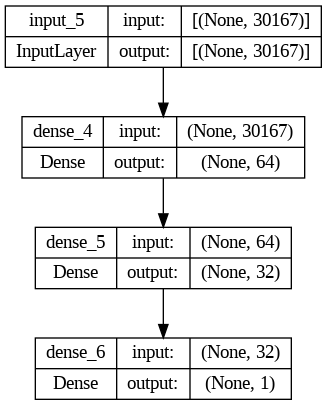

In [68]:
#TODO: Affichez le plot du modèle
from keras.models import *

keras.utils.plot_model(model, "model.png", show_shapes=True)

Entraînez le modèle sur les données d'entrainement en utilisant :
- SGD comme optimiseur avec un learning rate de 0.001
- BinaryCrossentropy comme fonction de coût
- Accuracy comme métrique

Utilisez 10 époques et une taille de lot (*batch size*) de 64. Pour la validation, utilisez 20% du jeu de données d'entraînement.

In [ ]:
#TODO: Insérez votre d'entrainement du modèle
model.fit(batch size = 64, 0.2)

Affichez les courbes d'*accuracy* et de *loss* pour les données d'entrainement et de validation.
- Est-ce que le modèle semble avoir atteint ses meilleures performances ?

In [ ]:
#TODO: Affichez les courbres d'accuracy et de loss pour durant l'entraînement et la validation
import matplotlib.pyplot as plt


Evaluez le modèle sur les données de test. Quelle est l'*accuracy* du modèle sur les données de test ?

In [ ]:
# TODO: Evaluez le modèle sur les données de test
test_results = #TODO: complétez le code

Affichez la matrice de confusion.

In [ ]:
#TODO: affichez la matrice de confusion et un rapport de classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report



# Améliorations

### Recherche d'hyperparamètres
- Utilisez `keras_tuner` pour la recherche d'hyperparamètres du modèle. Pour cela, faites varier le `learning_rate` de 0.0001 à 0.1 (multiplier par 10 à chaque fois)

Plus d'information sur `keras_tuner` dans ce [tutoriel](https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=fr)



### Modification du poids des classes
- La méthode `fit` vous permet de modifier l'importance d'une classes par rapport à une autre durant l'entraînement. Pour cela, il suffit de passer un dictionnaire à l'argument `class_weight` de la méthode `fit`. Plus d'information dans la [documentation](https://keras.io/api/models/model_training_apis/#fit-method) de la méthode `fit`.

